# Deep learning model
In this notebook, various deep learning classifiers will be trained to correctly classify spectrograms of gait data corresponding to one of three neuro-degenerative diseases or healthy (control) subjects.

## Setup

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

# had to change to tensorflow's keras implementation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras import optimizers
from tensorflow.keras import initializers

import tensorflow.keras.backend as K

%matplotlib inline

## Data
The dataset is imported from the corresponding directory. Each example consists of a $h \times w$ matrix, which corresponds to the spectrogram generated from the original signals (unlike with RGB images the inputs have only one channel).

The $m$ data points will be divided into a set for training and a set for validation (for hyperparameter tuning and model selection) following a 80/20 split.

In [10]:
rootdir = os.pardir
in_dir = os.path.join(rootdir, 'data/processed')

train_data = np.load(os.path.join(in_dir, 'train.npz'))
test_data = np.load(os.path.join(in_dir, 'test.npz'))

X_orig = train_data['X_train']
Y_orig = train_data['Y_train']
X_test_orig = test_data['X_test']
Y_test_orig = test_data['Y_test']

X_orig = X_orig.reshape(X_orig.shape[0], X_orig.shape[1],
                        X_orig.shape[2], 1)
X_test_orig = X_test_orig.reshape(X_test_orig.shape[0], X_test_orig.shape[1],
                        X_test_orig.shape[2], 1)

X_train_orig, X_dev_orig, Y_train_orig, Y_dev_orig = train_test_split(
    X_orig, Y_orig, random_state=1, test_size=0.20) # random state -> seed to always keep the same split

In [11]:
# check dimensions
print(X_train_orig.shape)
print(Y_train_orig.shape)
print(X_dev_orig.shape)
print(Y_dev_orig.shape)

(833, 11, 34, 1)
(833, 1)
(209, 11, 34, 1)
(209, 1)


In [12]:
# normalize inputs - maybe other way?? by batch?
X_train = (X_train_orig - X_train_orig.mean()) / X_train_orig.std()
X_dev = (X_dev_orig - X_dev_orig.mean()) / X_dev_orig.std()

Y_train = Y_train_orig
Y_dev = Y_dev_orig

## Classifiers

### One classifier per class
In order to reduce the number of parameters (weights) that will have to be trained, a classifier for each class will be trained, in a one-vs-all approach.

### Convolutional Neural Networks and other approaches
As a first approach, the candidate classifiers will be convolutional neural networks that input a 1-channel image (or matrix), which corresponds to the spectrogram calculated in previous steps.

Other possible approaches that could be taken could be
* Two-dimensional 2-channel Convolutional Neural Networks that input, as a single example, bothe left and right channels' spectrograms
* One-dimensional 1-channel Convolutional Neural Networks that input segments of the raw gait sensor signal (from either a left or a right foot sensor)
* One-dimensional 2-channel Convolutional Neural Networks that input both left and right channels' raw sensor data

*Note: The approaches described above could also benefit from Transfer Learning given the small size of the dataset*

Further, the data processing steps could be modified to acomodate for example:
* Finer segmentation of original records, which woulld generate more training examples
* Different parameters for time-frequency processing (spectrogram generation)

### Hyperparameters
Many hyperparameters can be considered in the selection of a model. In this notebook, only the CNN **architecture** will be explored.

Other aspects such as initialization of weights, optimization algorithms or activation functions will be fixed, as explained below:

1. **Initialization**: weights will be initialized using He initialization and bias parameters will be initialized to zeros.
2. **Loss function**: the loss function will be the engative log-likelihood (which is the same as the binary cross-entropy).
3. **Optimization algorithm**: the weights will be updated using Adam.
4. The **activation function**: ReLU will be used for all layers except for the output unit (sigmoid)
5. The **learning rate**: although it is one of the most important hyperparameters to tune, for now it has been set to 0.0001
6. **Dropout** rates have been set to 0 (no dropout at all) in all layers
7. The number of **epochs** used for training has also been fixed at 200
8. The **batch size** will be set to 128 traning examples

In further work, some of these hypeparameters (namely the leraning rate, droput rates number of epochs and batch size) will be evaluated.

### Proposed CNN architectures
Different Convolutional architectures will be trained. Given the small amount of data, which could easily lead to overfitting, these networks are particularly reduced in terms of number of parameters.

The architectures are described below using the following convention:

```
CONV -- convolutional layer
    n -- number of filters or kernels
    f -- size of filters
    s -- stride in each dimension
    pad -- padding in each dimension

MAXPOOL -- maxpooling layer
    (f1, f2) -- window size, which is equal to the stride

FC -- fully connected or dense layer

sigmoid -- refers to a single unit layer (the output layer) with the sigmoid activation function

```

| Architecture | Layer 1                                       | Layer 2        | Layer 3                                        | Layer 4        | Layer 5 | Layer 6 | Layer 7 |
|--------------|-----------------------------------------------|----------------|------------------------------------------------|----------------|---------|---------|---------|
| CNN_1A       | CONV (n=2; f=(1, 3); s=(1, 1); pad=(0, 1)) | MAXPOOL (1, 3) | CONV (n=2; f=(3, 3); s=(2, 2); pad=(1, 1))  | MAXPOOL (3, 3) | Flatten | FC (12) | sigmoid |
| CNN_1B       | CONV (n=2; f=(1, 3); s=(1, 1); pad=(0, 1)) | MAXPOOL (1, 3) | CONV (n=4; f=(3, 3); s=(2, 2); pad=(1, 1))  | MAXPOOL (3, 3) | Flatten | FC (20) | sigmoid |
| CNN_1C       | CONV (n=8; f=(1, 3); s=(1, 1); pad=(0, 1)) | MAXPOOL (1, 3) | CONV (n=16; f=(3, 3); s=(2, 2); pad=(1, 1)) | MAXPOOL (3, 3) | Flatten | FC (96) | sigmoid |
| CNN_2A       | CONV (n=2; f=(2, 3); s=(1, 1); pad=(0, 1)) | MAXPOOL (2, 2) | CONV (n=2; f=(3, 3); s=(2, 2); pad=(0, 0))  | MAXPOOL (2, 2) | Flatten | FC (12) | sigmoid |
| CNN_2B       | CONV (n=2; f=(1, 3); s=(1, 1); pad=(0, 1)) | MAXPOOL (1, 3) | CONV (n=4; f=(3, 3); s=(2, 2); pad=(0, 0))  | MAXPOOL (2, 2) | Flatten | FC (20) | sigmoid |

In [17]:
# these models dont seem to work well!
def get_CNN_1A(dropout_rate_conv, dropout_rate_dense):
    """
    The function defines the CNN_1A model
    
    Arguments:
    dropout_rate_conv -- hyperparameter controlling the dropout rate
        for conv layers
    dropout_rate_dense -- hyperparameter controlling the dropout rate
        for dense (fully connected) layers
    
    Returns:
    model -- keras model
    """
    model = Sequential()
    
    model.add(ZeroPadding2D(padding=(0, 1), input_shape=(11, 34, 1)))
    model.add(Conv2D(2, (1, 3), strides=(1, 1),
                     activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(1, 3))) # last column being dropped
    model.add(Dropout(dropout_rate_conv))
    
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(2, (3, 3), strides=(2, 2),
                    activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(dropout_rate_conv))
    
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(dropout_rate_dense))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

def get_CNN_1B(dropout_rate_conv, dropout_rate_dense):
    """
    The function defines the CNN_1B model
    
    Arguments:
    dropout_rate_conv -- hyperparameter controlling the dropout rate
        for conv layers
    dropout_rate_dense -- hyperparameter controlling the dropout rate
        for dense (fully connected) layers
    
    Returns:
    model -- keras model
    """
    model = Sequential()
    
    model.add(ZeroPadding2D(padding=(0, 1), input_shape=(11, 34, 1)))
    model.add(Conv2D(2, (1, 3), strides=(1, 1),
                     activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(1, 3)))
    model.add(Dropout(dropout_rate_conv))
    
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(4, (3, 3), strides=(2, 2),
                    activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(dropout_rate_conv))
    
    model.add(Flatten())
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(dropout_rate_dense))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

def get_CNN_2A(dropout_rate_conv, dropout_rate_dense):
    """
    The function defines the CNN_2A model
    
    Arguments:
    dropout_rate_conv -- hyperparameter controlling the dropout rate
        for conv layers
    dropout_rate_dense -- hyperparameter controlling the dropout rate
        for dense (fully connected) layers
    
    Returns:
    model -- keras model
    """
    model = Sequential()
    
    model.add(ZeroPadding2D(padding=(0, 1), input_shape=(11, 34, 1)))
    model.add(Conv2D(2, (2, 3), strides=(1, 1),
                     activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate_conv))
    
    model.add(Conv2D(2, (3, 3), strides=(2, 2),
                    activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate_conv))
    
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(dropout_rate_dense))
    model.add(Dense(1, activation='sigmoid'))
    
    return model


def get_CNN_2B(dropout_rate_conv, dropout_rate_dense):
    """
    The function defines the CNN_2A model
    
    Arguments:
    dropout_rate_conv -- hyperparameter controlling the dropout rate
        for conv layers
    dropout_rate_dense -- hyperparameter controlling the dropout rate
        for dense (fully connected) layers
    
    Returns:
    model -- keras model
    """
    model = Sequential()
    
    model.add(ZeroPadding2D(padding=(0, 1), input_shape=(11, 34, 1)))
    model.add(Conv2D(2, (2, 3), strides=(1, 1),
                     activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate_conv))
    
    model.add(Conv2D(4, (3, 3), strides=(2, 2),
                    activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate_conv))
    
    model.add(Flatten())
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(dropout_rate_dense))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [18]:
def get_CNN_1C(dropout_rate_conv, dropout_rate_dense):
    """
    The function defines the CNN_1C model
    
    Arguments:
    dropout_rate_conv -- hyperparameter controlling the dropout rate
        for conv layers
    dropout_rate_dense -- hyperparameter controlling the dropout rate
        for dense (fully connected) layers
    
    Returns:
    model -- keras model
    """
    model = Sequential()
    
    model.add(ZeroPadding2D(padding=(0, 1), input_shape=(11, 34, 1)))
    model.add(Conv2D(8, (1, 3), strides=(1, 1),
                     activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(1, 3))) # last column being dropped
    model.add(Dropout(dropout_rate_conv))
    
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(16, (3, 3), strides=(2, 2),
                    activation='relu', use_bias=True,
                    kernel_initializer='glorot_normal', bias_initializer='zeros'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(dropout_rate_conv))
    
    model.add(Flatten())
    model.add(Dense(96, activation='relu'))
    model.add(Dropout(dropout_rate_dense))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

A function to get the optimizer (Adam) with a given learning rate is also defined.

In [19]:
def get_optimizer(learning_rate):
    optimizer = optimizers.Adam(lr=learning_rate) # could use lr decay
    return optimizer

### Performance metrics

Various metrics will be evaluated when training each possible model, namely:

- Accuracy
- Precision
- Recall
- F1 Score

as well as the loss on the training and validation data.

Precision, recall and F1-score depend on the **threshold** we set, that is:
```
if p(y == class | model, x) > threshold ---> predict class
```

(at the moment the threshold is 0.5).

For now, the evaluated metric will be loss on the validation set, since accuracy is not a reliable measure of model performance due to class imbalance and the goals regarding precision and recall have not been defined yet.

In [20]:
# metrics need to be defined according to Keras' standards
# using the backend (tensorflow) tensor operations
def precision(y_true, y_pred):
    """Precision metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (total_positives + K.epsilon())
    return recall


def f1_score(y_true, y_pred):
    """Computes the F score.
    The F score is the weighted harmonic mean of precision and recall.
    """
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1_score = 2 * (p * r) / (p + r + K.epsilon())
    return f1_score

In [21]:
custom_metrics = ['accuracy', precision, recall, f1_score] # which one to use to evaluate model? accuracy or f1-score?

## Label redefinition
Since one classifier per class will be built, the original labels need to be converted to binary labels in each case

In [22]:
# redefinition of labels depending on each case
def redefine_labels(Y, target_class):
    """
    Transforms a K-labelled vector into a binary label vector. If Y[i] is equal to target_class
        then Y_binary[i] is 1. Otherwise, Y[i] is 0
    
    Arguments
    Y -- A (m, 1) NumPy array of labels ranging from 0 to (K - 1) with K being the number of classes
    target_class -- Integer indicating the target class
    
    Returns
    Y_binary -- A binary labelled (0 or 1) NumPy array of the same shape as Y
    """
    
    Y_binary = (Y == target_class).astype(int)
    return Y_binary

## Training and model evaluation

In [23]:
def plot_losses(losses):
    fig = plt.figure()
    ax = plt.axes()
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    plt.plot(np.arange(1, len(losses)+1), losses)
    return None

In [24]:
def train_model(hyperparameters, custom_metrics, X_train, Y_train, X_dev, Y_dev):
    
    # get hparams
    learning_rate = hyperparameters['lr']
    dropout_conv_rate = hyperparameters['dropout_conv']
    dropout_dense_rate = hyperparameters['dropout_dense']
    n_epochs = hyperparameters['epochs']
    get_model = hyperparameters['architecture'][1]

    # build model
    model = get_model(dropout_conv_rate, dropout_dense_rate)
    optimizer = get_optimizer(learning_rate)
    model.compile(optimizer=optimizer,
                 metrics=custom_metrics,
                 loss='binary_crossentropy')
    
    # train model
    history = model.fit(X_train, Y_train, batch_size=128, epochs=n_epochs,
              validation_data=(X_dev, Y_dev))
    
    # plot losses
    plot_losses(history.history['loss'])

    return model, history

In [1]:
# hyperparameters will be stored in a dict
hyperparameters = dict()

### Save models and history dictionaries
Since training can be costly it is a good idea to save the trained models as well as the evolution of metrics during training.

In [26]:
import time
import pickle

def save_model_and_history(model, history, hyperparameters, name):
    rootdir = os.pardir
    out_dir = os.path.join(rootdir, 'trained_models')
    stamp = time.strftime('%Y%m%d-%H%M%S')
    
    # save model architecture and weigths
    model_path = os.path.join(out_dir, name + '.h5')
    model.save(model_path)
    
    # save history
    history_dict = history.history
    with open(os.path.join(out_dir, '_'.join([name, 'hist.pickle'])), 'wb') as handle:
        pickle.dump(history_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # save hyperparameters
    with open(os.path.join(out_dir, '_'.join([name, 'hparams.pickle'])), 'wb') as handle:
        pickle.dump(hyperparameters,  handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return None

### ALS classifier
Let's start with the classifier that distinguishes ALS records from the rest.

Only two architectures will be compared below: architecture CNN_1A and CNN_1C, since architectures 1A, 1B, 2A and 2B gave similar (poor) performances. The same approach will be taken for the rest of the classifiers.

In [39]:
disease = 'ALS'

In [40]:
Y_train_als = redefine_labels(Y_train, 1)
Y_dev_als = redefine_labels(Y_dev, 1)

In [ ]:
hyperparameters['architecture'] = ('1A', get_CNN_1A)
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_als, X_dev, Y_dev_als)

name = '_'.join([disease, hyperparameters['architecture'][0]])

save_model_and_history(model, history, hyperparameters, name)

model_1A = model
history_1A = history.history

In [ ]:
hyperparameters['architecture'] = ('1C', get_CNN_1C)
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_als, X_dev, Y_dev_als)

name = '_'.join([disease, hyperparameters['architecture'][0]])

save_model_and_history(model, history, hyperparameters, name)

model_1C = model
history_1C = history.history

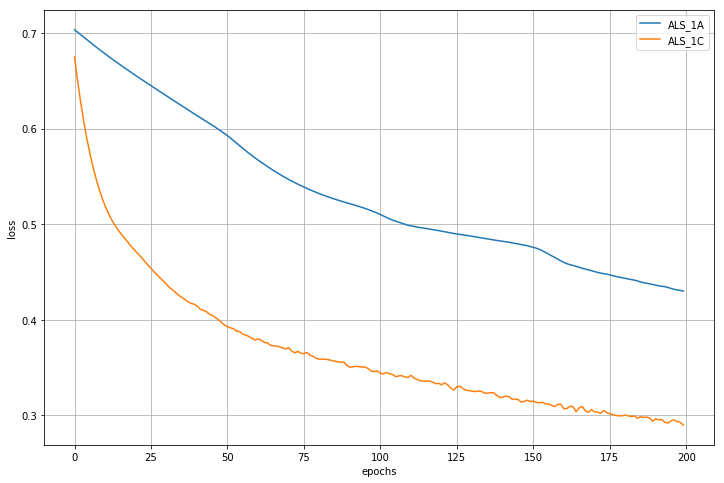

In [43]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
plt.grid()

ax.plot(history_1A['val_loss'], label=disease+'_1A')
ax.plot(history_1C['val_loss'], label=disease+'_1C')

ax.legend()

### Huntington's disease classifier

In [31]:
disease = 'hunt'

In [32]:
Y_train_hunt = redefine_labels(Y_train, 2)
Y_dev_hunt = redefine_labels(Y_dev, 2)

In [ ]:
hyperparameters['architecture'] = ('1A', get_CNN_1A)
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_hunt, X_dev, Y_dev_hunt)

name = '_'.join([disease, hyperparameters['architecture'][0]])

save_model_and_history(model, history, hyperparameters, name)

model_1A = model
history_1A = history.history

In [ ]:
hyperparameters['architecture'] = ('1C', get_CNN_1C)
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_hunt, X_dev, Y_dev_hunt)

name = '_'.join([disease, hyperparameters['architecture'][0]])

save_model_and_history(model, history, hyperparameters, name)

model_1C = model
history_1C = history.history

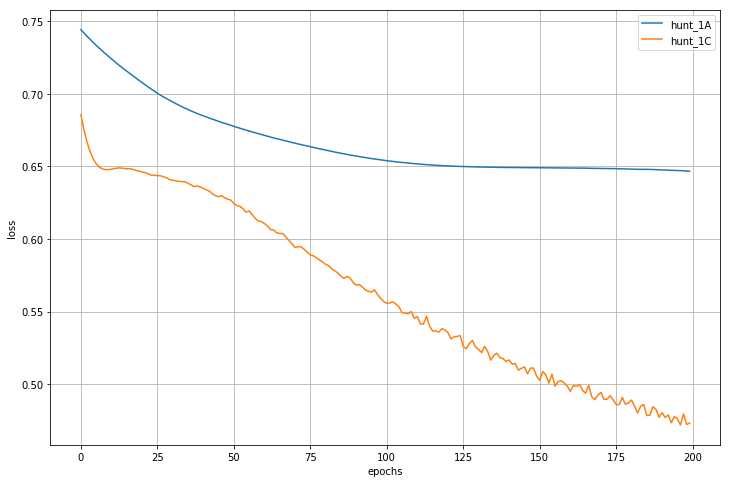

In [35]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
plt.grid()

ax.plot(history_1A['val_loss'], label=disease+'_1A')
ax.plot(history_1C['val_loss'], label=disease+'_1C')

ax.legend()

### Parkinson's disease classifier

In [41]:
disease = 'park'

In [42]:
Y_train_park = redefine_labels(Y_train, 3)
Y_dev_park = redefine_labels(Y_dev, 3)

In [ ]:
hyperparameters['architecture'] = ('1A', get_CNN_1A)
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_park, X_dev, Y_dev_park)

name = '_'.join([disease, hyperparameters['architecture'][0]])

save_model_and_history(model, history, hyperparameters, name)

model_1A = model
history_1A = history.history

In [ ]:
hyperparameters['architecture'] = ('1C', get_CNN_1C)
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_park, X_dev, Y_dev_park)

name = '_'.join([disease, hyperparameters['architecture'][0]])

save_model_and_history(model, history, hyperparameters, name)

model_1C = model
history_1C = history.history

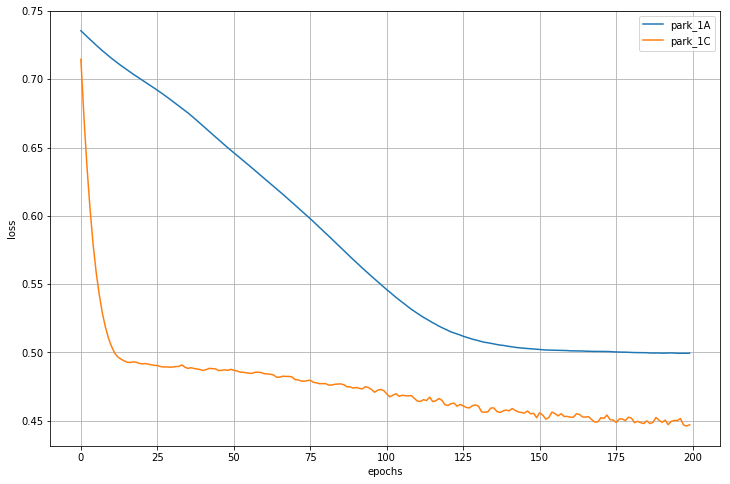

In [45]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
plt.grid()

ax.plot(history_1A['val_loss'], label=disease+'_1A')
ax.plot(history_1C['val_loss'], label=disease+'_1C')

ax.legend()

### Control subject classifier

In [52]:
disease = 'control'

In [53]:
Y_train_control = redefine_labels(Y_train, 0)
Y_dev_control = redefine_labels(Y_dev, 0)

In [ ]:
hyperparameters['architecture'] = ('1A', get_CNN_1A)
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_control, X_dev, Y_dev_control)

name = '_'.join([disease, hyperparameters['architecture'][0]])

save_model_and_history(model, history, hyperparameters, name)

model_1A = model
history_1A = history.history

In [ ]:
hyperparameters['architecture'] = ('1C', get_CNN_1C)
hyperparameters['lr'] = 0.0001
hyperparameters['dropout_conv'] = 0
hyperparameters['dropout_dense'] = 0
hyperparameters['epochs'] = 200

model, history = train_model(hyperparameters, custom_metrics,
                             X_train, Y_train_control, X_dev, Y_dev_control)

name = '_'.join([disease, hyperparameters['architecture'][0]])

save_model_and_history(model, history, hyperparameters, name)

model_1C = model
history_1c = history.history

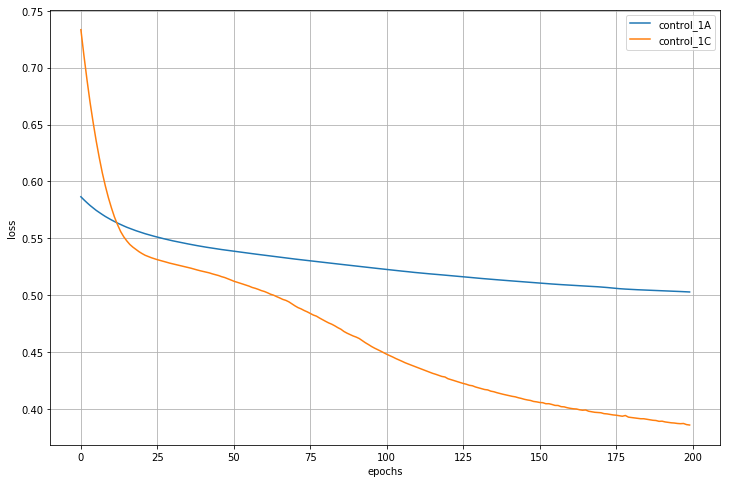

In [56]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
plt.grid()

ax.plot(history_1A['val_loss'], label=disease+'_1A')
ax.plot(history_1C['val_loss'], label=disease+'_1C')

ax.legend()

The CNN_1A models yield zero precision and recall. These models predict every example as a negative, which, due to class imbalance, gives accuracies in the order of 80%, a misleading figure. These models completely fail to predict the target class.

The CNN_1B models show some improvement. Precision and recall are not zero anymore, although they are still far from ideal. The validation loss is, in all 4 cases, significantly lower than the validation loss with the CNN_1A models.

Thus, the more complicated model seems to yield better results (lower loss) on the validation set. More complex models can lead to overfitting, specially with a small training set. In this case not only the loss on the train set is reduced but also the loss on the dev (validation) set, and the precision and recall obtained seem to indicate that we are far from overfitting.

*Note: Could there be a risk of overfitting the dev set? The data in the dev set pertains to the same individuals in the train set. The segments in train and dev set might be too similar, resulting in the models overfitting to certain individuals, while failing to predict correctly on previously unseen individuals.*

***
## Conclusions

Some initial models (Convolutional Neural Networks) for gait data classification were defined, trained, evaluated and compared. In general, the performance of the models with higher number of filters in the convolutional layers is better. However, the results for these models in all four classification tasks (ALS, hunt, park and control) still yield low precision and, specially, low recall (for a predicition threshold of 0.5).

### Main points to address

**Architecture:**

The model architectures were chosen to reduce the input size and the number of parameters involved through convolution and pooling layers. However, there are plenty of possibilities regarding architecture (number of layers, size of filters, number of filters, ...) and only a variation in the number of filters was examined.

An exhaustive assessment of the performance of all the possible models would be too costly but some hyperparameter tuning in this concern will need to be carried out. Some heuristics regarding CNN architecture would also help in the process.

**Hyperparameters:**

Many other hyperparameters have yet to be evaluated: learning rate, optimization algorithm, training epochs or batch size for example.

**What metric should we use to evaluate the models?**
* **Problems**:
    * For each classifier, data will be skewed (approximately 25% will be positives)
    * We do not have at the moment a limit on the False Positive Rate: *how many (negative) cases can we allow to be classified with the disease?*
    * We do not have at the moment a limit on the False Negative Rate: *how many (positive, with disease) cases can we allow to be classified as not having that disease?*
    * Maybe it is better to have a false positive than a false negative?
- Precision, recall and F1-Score depend on threshold we set
- It might be interesting to calculate other metrics such as the ROC AUC, which does not depend on the threshold

***